In [1]:
import wandb
import torch
import sklearn
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from simpletransformers.classification import MultiLabelClassificationModel, MultiLabelClassificationArgs

In [2]:
# see GPU avaialability
cuda_available = torch.cuda.is_available()

% PER CLASS:

 SDG1      4.688020
SDG2      2.671225
SDG3      6.316593
SDG4      7.484520
SDG5     15.656094
SDG6      1.353229
SDG7      0.324279
SDG8     10.893040
SDG9      0.559170
SDG10    10.140086
SDG11     2.903506
SDG12     0.972185
SDG13     0.999589
SDG14     0.289046
SDG15     0.373215
SDG16    28.618779
SDG17     5.757424
dtype: float64


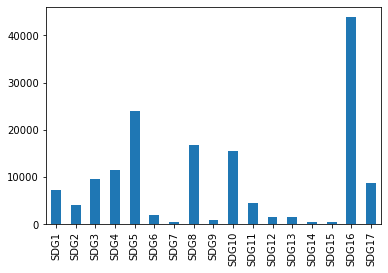

In [3]:
# import data
data = pd.read_csv('OneHot_Combined_cln_utf8.tsv', sep='\t')

# reformat data
sdg_lst = ['SDG1','SDG2','SDG3','SDG4','SDG5','SDG6','SDG7','SDG8','SDG9','SDG10','SDG11','SDG12','SDG13','SDG14','SDG15','SDG16','SDG17']
data['y'] = data[sdg_lst].values.tolist()
y = data['y']
X = data['abstract']

# plot ratio of data
class_weight = (data[sdg_lst].sum()/ data[sdg_lst].sum().sum())
print('% PER CLASS:\n\n', class_weight*100)
data[sdg_lst].sum().plot.bar()

# split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# add data to dataframes
train_df = pd.DataFrame()
train_df['text'] = X_train
train_df['labels'] = y_train
train_df.reset_index(inplace=True, drop=True)

eval_df = pd.DataFrame()
eval_df['text'] = X_val
eval_df['labels'] = y_val
eval_df.reset_index(inplace=True, drop=True)

# get number of classes
label_count = len(sdg_lst)

In [4]:
# parameter optimisation
sweep_config = {
    "method": "bayes",  # bayes, grid, random
    "metric": {"name": "accuracy", "goal": "maximize"},
    "parameters": {
        "num_train_epochs": {"min": 1, "max": 10},
        "learning_rate": {"min": 5e-5, "max": 4e-4},
        "train_batch_size":{"min": 5, "max": 15},
        "eval_batch_size":{"min": 5, "max": 15},
        "warmup_steps":{"min": 50, "max": 500},
        "weight_decay":{"min": 0.01, "max": 0.1},
        "logging_steps":{"values": [2, 5, 10]},
    },
}

sweep_id = wandb.sweep(sweep_config, entity='sasdghub', project="sasdghub_ml_classify")

# logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

Create sweep with ID: aphc3kx2
Sweep URL: https://wandb.ai/sasdghub/sasdghub_ml_classify/sweeps/aphc3kx2


In [5]:
def acc_result(true, pred):
    true=np.argmax(true, axis=1)
    pred=np.argmax(pred, axis=1)
    acc = sklearn.metrics.accuracy_score(true, pred)
    return acc

def f1_result(true, pred):
    true=np.argmax(true, axis=1)
    pred=np.argmax(pred, axis=1)
    f1 = sklearn.metrics.f1_score(true, pred, average='micro')
    return f1

def cm_result(true, pred):
    true=np.argmax(true, axis=1)
    pred=np.argmax(pred, axis=1)
    cm = wandb.plot.confusion_matrix(probs=None, y_true=true, preds=pred, class_names=sdg_lst) #sklearn.metrics.multilabel_confusion_matrix(true, pred)
    return cm

In [ ]:
# Optional model configuration
model_args = MultiLabelClassificationArgs(fp16= False,
                                          threshold=0.8,
                                          manual_seed = 4,
                                          use_multiprocessing = True,
                                          overwrite_output_dir=True,
                                          evaluate_during_training = True,
                                          # wandb_project = 'sasdghub_ml_classify',
                                          # wandb_kwargs={
                                          #     'entity':'sasdghub'
                                          #              },
                                          # num_train_epochs=1,
                                          # train_batch_size= 16,
                                          # eval_batch_size= 64,
                                          # warmup_steps= 500,
                                          # weight_decay= 0.01,
                                          # logging_steps= 10,
                                          # learning_rate= 5e-5
                                          
                                         )

def train():
    
    # Initialize a new wandb run 
    wandb.init()

    # Create a MultiLabelClassificationModel
    model = MultiLabelClassificationModel(
        "xlnet",
        "xlnet-base-cased",
        num_labels=label_count,
        args=model_args,
        use_cuda=cuda_available,
        pos_weight=list(1-class_weight),
        # show_running_loss=True,
        sweep_config=wandb.config,
    )
    
    # Train the model
    model.train_model(train_df,
                      verbose=True,
                      eval_df=eval_df,
                      accuracy=acc_result,
                      f1=f1_result,
                      cm=cm_result)
    
    # Evaluate the model
    result, model_outputs, wrong_predictions = model.eval_model(
        eval_df,
        verbose=True,
        accuracy=acc_result,
        f1=f1_result,
        cm=cm_result
    )
    
    # Sync wandb
    wandb.join()
    
wandb.agent(sweep_id, train)

INFO:wandb.agents.pyagent:Starting sweep agent: entity=None, project=None, count=None
wandb: Agent Starting Run: sufzhhi7 with config:
wandb: 	eval_batch_size: 14
wandb: 	learning_rate: 0.000217051284755148
wandb: 	logging_steps: 5
wandb: 	num_train_epochs: 6
wandb: 	train_batch_size: 11
wandb: 	warmup_steps: 109
wandb: 	weight_decay: 0.051953330108910026
wandb: Currently logged in as: christopher-marais (sasdghub). Use `wandb login --relogin` to force relogin


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForMultiLabelSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForMultiLabelSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream tas

  0%|          | 0/63940 [00:00<?, ?it/s]

In [ ]:
# train with optimal parameters
# # logging
# logging.basicConfig(level=logging.INFO)
# transformers_logger = logging.getLogger("transformers")
# transformers_logger.setLevel(logging.WARNING)

# # Optional model configuration
# model_args = MultiLabelClassificationArgs(fp16= False,
#                                           threshold=0.8,
#                                           manual_seed = 4,
#                                           use_multiprocessing = True,
#                                           overwrite_output_dir=True,
#                                           evaluate_during_training = True,
#                                           wandb_project = 'sasdghub_ml_classify',
#                                           wandb_kwargs={
#                                               'entity':'sasdghub'
#                                                        },
#                                           num_train_epochs=1,
#                                           train_batch_size= 16,
#                                           eval_batch_size= 64,
#                                           warmup_steps= 500,
#                                           weight_decay= 0.01,
#                                           logging_steps= 10,
#                                           learning_rate= 5e-5
                                          
#                                          )

# # Create a MultiLabelClassificationModel
# model = MultiLabelClassificationModel(
#     "xlnet",
#     "xlnet-base-cased",
#     num_labels=label_count,
#     args=model_args,
#     use_cuda=cuda_available,
#     pos_weight=list(1-class_weight),
    # show_running_loss=True,
    # sweep_config=wandb.config,
# )

# # Train the model
# model.train_model(train_df,
#                   verbose=True,
#                   eval_df=eval_df)

# # Evaluate the model
# result, model_outputs, wrong_predictions = model.eval_model(
#     eval_df,
#     verbose=True,
# )

In [ ]:
# Make predictions with the model
# predictions, raw_outputs = model.predict(["sanitation and clean drinking water"])

#######################################################################################



for validate use:
accuracy
f1
confusion matrices

get backpropagation pos_weight to be normalized around 1 with classes with a lot of data to be less than 1 and classes with less to be more than 1

modify so it can digest longer text (split training data into paragraphs that can be digested)

make testing dataset and train real classifier

run multiple models against one another

save model
apply new model in apply script

make testing script with ROC curves and confusion matrices (model.eval)

get model embedding
train classifier for targets
OR
force nodes for each SDG to output only to targets (SDG7 node does not link to target 9.5 but only to 7.x targets.)